# Importação dos pacotes

---



In [7]:
from fastai.vision.all import *

# Importação da base de dados

---



In [ ]:
!mkdir assets
!wget -O ./assets/dataset.zip https://github.com/kamillafsilva/cv-coral-classification/blob/main/archive.zip?raw=true
!unzip '/content/assets/dataset.zip' -d '/content/assets/dataset'

# Treinando o modelo

---



Para leitura dos dados o método `from_folder` espera que a pasta com os dados esteja estruturada da seguinte forma:

```
ROOT
| -- train
| ---- class_1
| ---- class_2
| -- valid
| ---- class_1
| ---- class_2

```

Nesse projeto temos:
*   *ROOT*: Bleached Corals and Healthy Corals Classification
*   *train*: Training
*   *valid*: Validation
*   *class_1*: bleached_corals (corais branqueados)
*   *class_2*: healthy_corals  (corais saudáveis)








In [12]:
path = '/content/assets/dataset/Bleached Corals and Healthy Corals Classification/'
dls = ImageDataLoaders.from_folder(path, train ='Training', valid = 'Validation', item_tfms=Resize(224))

Podemos verificar algumas das imagens carregadas com o método `show_batch`:

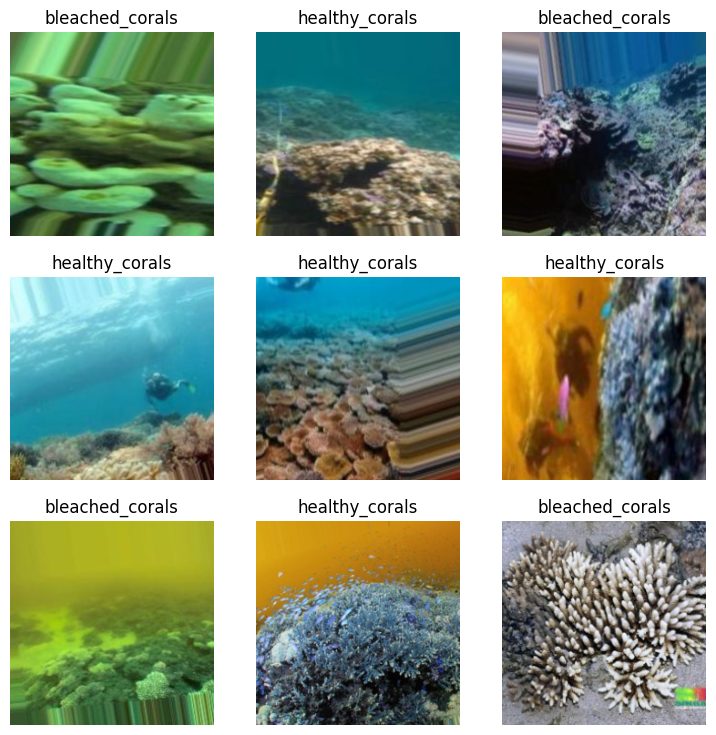

In [13]:
dls.show_batch()

Para classificação dos corais podemos utilizar um modelo pré treinado do pacote `fastai` e adapta-lo ao problema em questão, essa técnica é chamada de aprendizado por transferência. Abaixo utilizamos o modelo [ResNet34](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) para essa tarefa:

In [14]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 81.8MB/s]


epoch,train_loss,valid_loss,accuracy,time


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

Treinando o modelo por 3 epochs conseguimos atingir 95,3% de acurácia no conjunto de validação. Podemos melhorar esse resultado utizando o valor ótimo para o parametro *learning rate* com o método `lr_find`:

In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn.fine_tune(3, lrs.valley)

Utilizando o valor ótimo para o *learning rate* alcançamos 95,8% de acurácia.

# Análisando os resultados

---



A matriz de confusão abaixo compara as classes observadas com as classes preditas pelo modelo. O modelo classificou corretamente 95% dos corais branqueados e 97% dos corais saudáveis.

In [ ]:
clf_interp = ClassificationInterpretation.from_learner(learn)
clf_interp.plot_confusion_matrix(normalize = True)

Também podemos verificar os casos em que os modelos fez os piores erros com o método `plot_top_losses`. Por exemplo, para imagem do canto superior esquerdo, o modelo classificou o coral como saúdavel com 99% de pobabilidade. No entanto, esse era um coral branqueado. Analisando esses casos os pesquisadores podem entender quais características das imagens coletadas causam confusão no modelo.

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

Por fim, o modelo treinado pode ser exportado para um arquivo com o método `export`:

In [ ]:
learn.export('/content/assets/coral_learn.pkl')

# Transfomando o modelo numa aplicação web

In [ ]:
! pip install gradio

In [4]:
import gradio as gr

In [5]:
coral_learn = load_learner('/content/assets/coral_learn.pkl')

NameError: name 'load_learner' is not defined

In [22]:
labels = coral_learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = coral_learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [1]:
demo = gr.Interface(fn=predict, inputs="image", outputs="label")
demo.launch()

NameError: name 'gr' is not defined